In [1]:
from pyspark.sql import SparkSession
from os import environ

In [2]:
spark = SparkSession.builder.appName('box_score_analysis').master('local[*]').getOrCreate()

22/07/22 10:46:32 WARN Utils: Your hostname, rpi3 resolves to a loopback address: 127.0.1.1; using 172.25.14.38 instead (on interface wlan0)
22/07/22 10:46:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/22 10:46:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
query = 'select players.name as name, A.*  from '
query += '(select teams.name as team, box_scores.* from box_scores inner join teams on ' 
query += 'team_id = id) ' 
query += 'A inner join players on player_id = id'


df = spark.read.format('jdbc').option('url','jdbc:mysql://localhost:3306/nba').\
    option('user',environ.get('USER')).option('password',environ.get('PSWD')).\
    option('query',query).load()

In [4]:
df = df.drop('player_id','team_id')

I have data on games from the 2011-12 to the 2021-22 NBA season. The data is on the regular and post season. 

In [5]:
import pyspark.sql.functions as F
df.select(F.min('game_day').alias('earliest_game'),F.max('game_day').alias('latest_game')).show()

+-------------+-----------+
|earliest_game|latest_game|
+-------------+-----------+
|   2011-12-25| 2022-06-16|
+-------------+-----------+



Select scoring and assist stats from the original df

In [6]:
scoring_stats = ['pts','fgm','fga','pm3','pa3','ftm','fta','ast']
identifiers = ['name','team', 'game_day']
label = ['result']
cols = identifiers+label+scoring_stats
scoring_df = df.select(*cols)

Compute some derived scoring stats

In [7]:
scoring_df = scoring_df.withColumn('ft%', scoring_df['ftm']/scoring_df['fta'])
scoring_df = scoring_df.withColumn('fg%', scoring_df['fgm']/scoring_df['fga'])
scoring_df = scoring_df.withColumn('3p%', scoring_df['pm3']/scoring_df['pa3'])
scoring_df = scoring_df.withColumn('2p%', 
            (scoring_df['fgm'] - scoring_df['pm3'])/(scoring_df['fga'] -scoring_df['pa3']))
scoring_df = scoring_df.withColumn('eFG%', (scoring_df['fgm'] + 0.5*scoring_df['pm3'])/scoring_df['fga'])

In [8]:
from pyspark.ml.feature import StringIndexer

Let's transform the result column in the following manner

$result \subset \{win, loss\}$  ==> $win \subset \{1,0\}$

Wins are transformed to 1 and losses are transformed to 0. 

In [9]:
result_labler = StringIndexer(inputCol='result',outputCol='win',
                stringOrderType='alphabetAsc').fit(scoring_df)

In [10]:
scoring_df = result_labler.transform(scoring_df)

In [11]:
scoring_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- team: string (nullable = true)
 |-- game_day: date (nullable = true)
 |-- result: string (nullable = true)
 |-- pts: integer (nullable = true)
 |-- fgm: integer (nullable = true)
 |-- fga: integer (nullable = true)
 |-- pm3: integer (nullable = true)
 |-- pa3: integer (nullable = true)
 |-- ftm: integer (nullable = true)
 |-- fta: integer (nullable = true)
 |-- ast: integer (nullable = true)
 |-- ft%: double (nullable = true)
 |-- fg%: double (nullable = true)
 |-- 3p%: double (nullable = true)
 |-- 2p%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- win: double (nullable = false)



# Exploratory analysis

Let's start with some descriptive statistics of the scoring stats.

In [12]:
scoring_df.select(*scoring_df.columns[4:]).toPandas().describe().round(4)

,pts,fgm,fga,pm3,pa3,ftm,fta,ast,ft%,fg%,3p%,2p%,eFG%,win
count,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,166381.0000,279167.0000,201886.0000,265440.0000,279167.0000,293686.000
mean,9.9248,3.6834,8.0747,0.9169,2.5699,1.6410,2.1493,2.1706,0.7519,0.4426,0.3258,0.4904,0.4972,0.501
std,8.1726,3.0578,5.7130,1.3216,2.7435,2.2736,2.7751,2.5061,0.2868,0.2363,0.3015,0.2813,0.2692,0.500
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
25%,4.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.3158,0.0000,0.3333,0.3333,0.000
50%,8.0000,3.0000,7.0000,0.0000,2.0000,1.0000,2.0000,1.0000,0.8333,0.4444,0.3333,0.5000,0.5000,1.000
75%,15.0000,5.0000,11.0000,1.0000,4.0000,2.0000,3.0000,3.0000,1.0000,0.5714,0.5000,0.6667,0.6667,1.000
max,70.0000,24.0000,50.0000,14.0000,24.0000,26.0000,39.0000,25.0000,1.0000,1.0000,1.0000,1.0000,1.5000,1.000


Summary statistics show:
- Teams typically play the same number of players
    - Because wins make up 50% of all records and only one team can win
    - There do not appear to be bulky or skeleton teams in the NBA
    - Balanced class labels for wins/results, meaning downstream classification tasks do not need make extra considerations for unbalanced classes
- The average player contributes to points mostly through 2pt shots. (3 point shots made show the 75th percentile at only 1 and the mean being 0.9). They also contribute through free throws, making about one a game.
    - The average player takes few 3 pt shots and hardly makes any
- Most made threes are made by specialised/specialist players. This shows as a skew in 3PM. This stat will need a log transform for machine learning or regression models.
- There is also a slight skew in assists that may indicate teams tend to rely on playmakers to make that final pass

It is possible that there will be null values as a result of zero division (not attempting to shoot). Effectively, if a player does not attempt a shot, their percentage is 0. The percentages should be used together with the attempts to distinguish between players who attempted but did not make a shot and others who did not attempt at all.

In [13]:
percentage_cols = [i for i in scoring_df.columns if '%' in i]
scoring_df = scoring_df.fillna(0,percentage_cols)

To further the exploratory analysis, I will attempt clustering to see what type of scorers exist in the NBA.

I employ k-means clustering, with $k=5$.

All columns will be scaled to range [0,1]. Percentage columns (with the exception of eFG% which is [0,1.5]) already follow this. This will prove useful for any clustering measures because feature vectors will be unit vectors and reduces the chances of the distance functions becoming intractible.

In [14]:
features = scoring_df.columns[4:-1]
to_scale = [i for i in features if  ('%' not in i) or i=='eFG%']
keep = [i for i in features if i not in to_scale]

Transformation stage

In [15]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

scale_assembler = VectorAssembler(inputCols=to_scale,outputCol='to_scale_features')
scoring_df = scale_assembler.transform(scoring_df)

keep_assembler = VectorAssembler(inputCols=keep,outputCol='unscaled_features')
scoring_df = keep_assembler.transform(scoring_df)

In [16]:
mm_scaler = MinMaxScaler(inputCol= 'to_scale_features', outputCol='scaled_features')
scaler = mm_scaler.fit(scoring_df)

scoring_df = scaler.transform(scoring_df)

In [17]:
assembler = VectorAssembler(inputCols=['scaled_features','unscaled_features'],outputCol = 'features')

scoring_df = assembler.transform(scoring_df)

With the features now ready, It is now possible to perform clustering. I will use K-Means with $2 <= k<= 13$ and select the best model with the elbow method after plotting the intracluster distance (or training cost) with respect to k.

In [18]:
from pyspark.ml.clustering import KMeans

Fitting the models

In [ ]:
errors = []
models ={}
for k in range(2,14):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(scoring_df)
    models['k_'+str(k)] = model
    errors.append(model.summary.trainingCost)
    key = 'k_'+str(k)
    model_path =  "../../kmeans_model_"+key # store model out of the repository
    model.save(model_path)
    intra_distance =model.computeCost(scoring_df)
    errors.append(intra_distance)

Plotting the results of training.

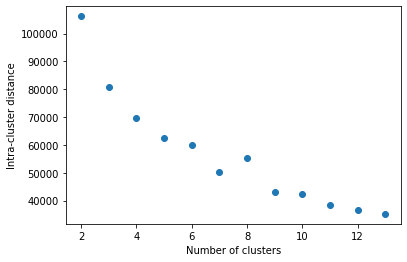

In [ ]:
import matplotlib.pyplot as plt
cluster_number = range(2,14)
plt.xlabel('Number of clusters')
plt.ylabel('Intra-cluster distance')
plt.scatter(cluster_number,errors)
plt.show()

It appears that 7 clusters performs well enough to segment the type of scoring stat lines in the NBA

In [19]:
from pyspark.ml.clustering import KMeansModel
    
model_path = '../../kmeans_models/kmeans_model_k_7'
model = KMeansModel.load(model_path)
preds = model.transform(scoring_df)

We can use a pivot table to count the wins and losses in each cluster and then calculate the win percentage within each cluster to see if there are any clusters that tend to have more winners.

In [29]:
pivot_table = preds.groupBy('prediction').pivot('result').count()
pivot_table = pivot_table.withColumn('win%',
                                F.round(pivot_table['W']/(pivot_table['L']+pivot_table['W']),3))

In [30]:
pivot_table.orderBy('win%',ascending = False).show()

+----------+-----+-----+-----+
|prediction|    L|    W| win%|
+----------+-----+-----+-----+
|         2|21600|27855|0.563|
|         3| 9953|12531|0.557|
|         6|17599|20100|0.533|
|         5|26707|26131|0.495|
|         4|25238|22578|0.472|
|         1|29731|26479|0.471|
|         0|15707|11477|0.422|
+----------+-----+-----+-----+



There does not appear to be a cluster or groups of clusters that contain players who win considerably more than others.

It is possible to do futher analysis by checking if there are particular clusters that contain certain teams, describe the scoring statistics within these clusters, etc.

In [31]:
players = preds.select('name','team',*preds.columns[3:18],'prediction')

Let's take a look at the averages of the scoring and assist statistics of the 7 clusters in our dataset

In [32]:
p_df = (players
.groupBy('prediction').avg()
.orderBy('prediction')
.drop('avg(prediction)')
.toPandas().round(3))

22/07/22 11:08:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [33]:
p_df.set_index('prediction')

,avg(pts),avg(fgm),avg(fga),avg(pm3),avg(pa3),avg(ftm),avg(fta),avg(ast),avg(ft%),avg(fg%),avg(3p%),avg(2p%),avg(eFG%),avg(win)
prediction,,,,,,,,,,,,,,
0,6.832,1.757,7.515,0.640,2.781,2.679,3.129,2.258,0.877,0.210,0.152,0.187,0.250,0.422
1,1.242,0.507,3.131,0.151,1.177,0.076,0.243,0.992,0.030,0.082,0.039,0.074,0.094,0.471
2,20.426,7.041,13.667,2.599,5.248,3.745,4.447,3.711,0.862,0.532,0.552,0.527,0.639,0.563
3,12.183,4.687,6.806,0.247,1.137,2.562,3.390,1.694,0.790,0.713,0.068,0.837,0.731,0.557
4,13.081,4.780,11.012,0.277,2.097,3.245,4.242,2.815,0.777,0.435,0.059,0.516,0.447,0.472
5,6.746,3.199,6.241,0.291,1.575,0.057,0.382,1.590,0.013,0.564,0.068,0.700,0.583,0.495
6,10.430,4.094,8.115,2.141,3.831,0.101,0.353,2.126,0.036,0.541,0.644,0.383,0.704,0.533


The highest scoring cluster (label 2) has an average if 20.4 points. These players are also quite efficient at the free throw line: FT% = 86.2 and make a high percentage of their 3 and 2 point shots: 3P% = 55.2% and 2P% = 52.7%. They also tend to have the highest number of assists. Players who "go off" will lie in this cluster. 

Let's examine the high scoring cluser in the dataset:
- We will start with the teams and see how many of their performances fall in the high scoring cluster relative to the other clusters
- We then move onto players to their performances as high scorers relative to other performances 
- And finally both players and teams to see if high scoring players put up the same performances on different teams

In [34]:
cluster_analysis = preds.select('name','team','prediction',*preds.columns[3:18])
top_scorers = cluster_analysis.filter(cluster_analysis['prediction']==2)

In [35]:
from pyspark.sql import Window

In [29]:
window = Window.partitionBy('team')
team_analysis = cluster_analysis.groupBy('team','prediction').count()
team_analysis = team_analysis.withColumn('totals',F.sum('count').over(window))
team_analysis = team_analysis.withColumn('cluster_share(%)',F.round(100*team_analysis['count']/team_analysis['totals'],2))

In [31]:
top_scoring_teams = team_analysis.filter(team_analysis['prediction']==2)

to_plot = top_scoring_teams.orderBy('cluster_share(%)',ascending=False).limit(5).withColumn('position',F.lit('top 5'))
to_plot = (to_plot.unionByName(top_scoring_teams.orderBy('cluster_share(%)',ascending=True)
.limit(5).withColumn('position',F.lit('last 5'))))

Let's visualise the shares and see the teams with the highest (top 5) and the lowest (last 5) shares in the high scoring cluster

In [ ]:
(to_plot
.orderBy('cluster_share(%)',ascending=False)
.to_pandas_on_spark()
.plot
.bar(y='cluster_share(%)',x='team',color='position'))

![TEAM](team_plot.png)


The Rockets have the highest proportion of player performances appearing in the high scoring cluster. The Spurs have the lowest proportion of their player performances in the high scoring cluster. It is worth further investigating this to see why the Spurs, a rather successful team (at least in the first half of this datases) shows up so low. An idea of where to start could be to see how system employed by Coach Popovich (one of the most established systems in the league) values scoring.

Teams show small differences in their proportions, which indicates that all teams have their go-to guy(s) to produce high scoring performances. 

Let's have a look at the underlying data in a table:

<!-- The Warriors have the highest share in the high scoring cluster. The Detroit Pistons have the smallest share. The difference between the top and bottom teams in this cluster is about 1%. All teams have similar shares in the high scoring cluster. High scoring players appear throughout the league regardless of team as shown in the table below -->

In [36]:
top_scoring_teams.orderBy('cluster_share(%)',ascending=False).toPandas().head(50)

,team,prediction,count,totals,cluster_share(%)
0,HOU,2,1901,9482,20.05
1,DEN,2,1831,9780,18.72
2,POR,2,1786,9746,18.33
3,MIN,2,1647,9053,18.19
4,BOS,2,1928,10673,18.06
5,GSW,2,1996,11146,17.91
6,CLE,2,1741,9844,17.69
7,OKC,2,1799,10182,17.67
8,PHX,2,1671,9478,17.63
9,ATL,2,1762,10047,17.54


In [38]:
window = Window.partitionBy('name')
player_analysis = cluster_analysis.groupBy('name','prediction').count()
player_analysis = player_analysis.withColumn('totals',F.sum('count').over(window))
player_analysis = player_analysis.withColumn('cluster_share(%)',F.round(100*player_analysis['count']/player_analysis['totals'],2))

In [41]:
top_scoring_players = player_analysis.filter(player_analysis['prediction']==2)

to_plot = top_scoring_players.orderBy('cluster_share(%)',ascending=False).limit(5).withColumn('position',F.lit('top 5'))
to_plot = (to_plot.unionByName(top_scoring_players.orderBy('cluster_share(%)',ascending=True)
.limit(5).withColumn('position',F.lit('last 5'))))

In [ ]:
(to_plot
.orderBy('cluster_share(%)',ascending=False)
.to_pandas_on_spark()
.plot
.bar(y='cluster_share(%)',x='name',color='position'))

![PLAYERS](player_plot.png)


We can see Steph Curry has the highest propotion of high scoring performance with 76%. Many of the top scorers in the league show up in the top 5. The vast difference between the top 5 and the last 5 shows how the scoring responsibility falls on particular players and every now and then the supporting players have high scoring games.

Let's have a look at the top 20 high scoring players in the league:

In [44]:
player_analysis.filter(player_analysis['prediction']==2).orderBy('cluster_share(%)',ascending=False).show()

+------------------+----------+-----+------+----------------+
|              name|prediction|count|totals|cluster_share(%)|
+------------------+----------+-----+------+----------------+
|     Stephen Curry|         2|  609|   806|           75.56|
|      Kevin Durant|         2|  570|   757|            75.3|
|      James Harden|         2|  669|   910|           73.52|
|       Luka Doncic|         2|  202|   292|           69.18|
|    Damian Lillard|         2|  523|   772|           67.75|
|  Donovan Mitchell|         2|  248|   384|           64.58|
|        Trae Young|         2|  191|   301|           63.46|
|      Kyrie Irving|         2|  430|   685|           62.77|
|      LeBron James|         2|  563|   913|           61.66|
|Karl-Anthony Towns|         2|  287|   493|           58.22|
|       Paul George|         2|  446|   779|           57.25|
|      Devin Booker|         2|  289|   509|           56.78|
|      Bradley Beal|         2|  390|   690|           56.52|
|   Anth

Let's have a look at the combination of players and the teams they played at. We can then see which teams relied on which players to put up high numbers during games.

In [36]:
window = Window.partitionBy('name','team')
player_team_analysis = cluster_analysis.groupBy('name','team','prediction').count()
player_team_analysis = player_team_analysis.withColumn('totals',F.sum('count').over(window))
player_team_analysis = (player_team_analysis
.withColumn('cluster_share(%)',
F.round(100*player_team_analysis['count']/player_team_analysis['totals'],2)))

In [67]:
top_scoring_players = player_team_analysis.filter(player_team_analysis['prediction']==2)

to_plot = (top_scoring_players
.filter(top_scoring_players['count']>50)
.orderBy('cluster_share(%)',ascending=False)
.limit(15)
.withColumn('position',F.lit('top 15')))

Let's plot the top fifteen highest proportion of high scoring performances and consider the teams at which they had these performances. We will consider players who have more than 50 performances in the high scoring cluster.

In [ ]:
fig = (to_plot
.orderBy('cluster_share(%)',ascending=False)
.to_pandas_on_spark()
.plot
.bar(x='cluster_share(%)',y='name',color='team',text='team',barmode='overlay'))

fig.update_layout(yaxis={'categoryorder':'max ascending'})

![PLAYER_TEAMS](player_team.png)


Kevin Durant has been a prominent scorer at every team he as been on. All teams have leaned on his scoring ability and he has delivered. It is interesting to note that he has his smallest proportion of high scoring performances when he was with the Warriors. While he was indispensible to the Warrior's back to back championships, his role as a high scorer saw a decrease compared to the other teams he has been on. The Nets have really leaned on Kevin Durant (which would explain their early exit in the 2021-22 playoffs) and he has delivered much more than he has not.